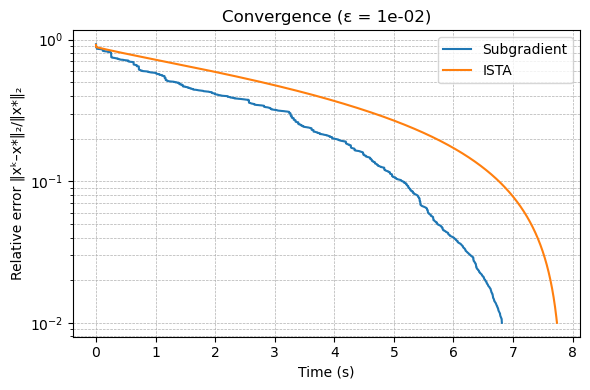

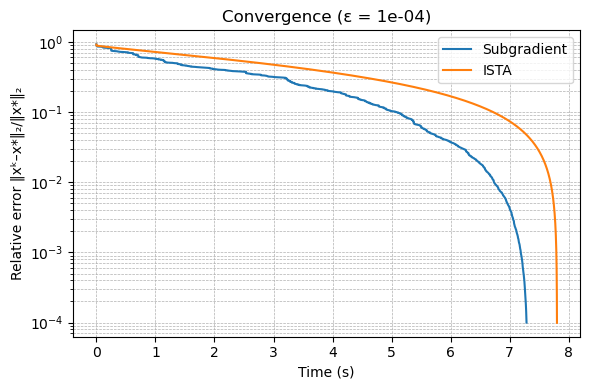

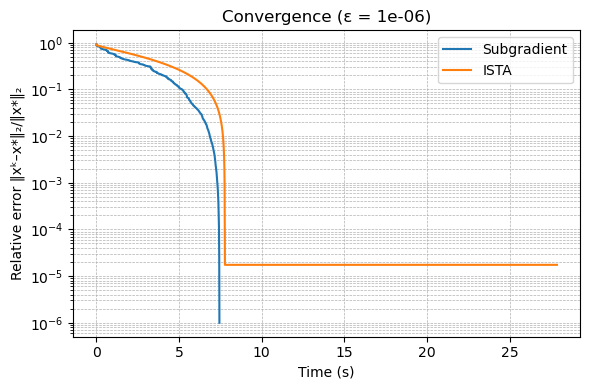

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ─── 1) Data generation ───────────────────────────────────────────────────────
m, n, s = 100, 500, 5
np.random.seed(0)
A = np.random.randn(m, n)
x_star = np.zeros(n)
p = np.random.permutation(n)
x_star[p[:s]] = np.random.randn(s)
b = A.dot(x_star)

# True objective at x*, used for f-diff
def objective(x, τ):
    return np.linalg.norm(A.dot(x) - b)**2 + τ * np.linalg.norm(x, 1)

# Soft‐thresholding operator
def soft_threshold(x, lam):
    return np.sign(x) * np.maximum(np.abs(x) - lam, 0.0)

def subgradient_optimal(A, b, τ, x0, eps, max_iter=1000000):
    x = x0.copy()
    f_star = objective(x_star, τ)
    errors, f_diffs = [], []
    t_start = time.time()

    for k in range(1, max_iter + 1):
        grad_g = 2 * A.T.dot(A.dot(x) - b)
        subgrad_h = τ * np.sign(x)
        gk = grad_g + subgrad_h

        g_norm_sq = np.linalg.norm(gk)**2
        if g_norm_sq == 0:
            break  # Already optimal

        t = (objective(x, τ) - f_star) / g_norm_sq
        x -= t * gk

        err = np.linalg.norm(x - x_star) / np.linalg.norm(x_star)
        errors.append(err)
        f_diffs.append(objective(x, τ) - f_star)
        if err < eps:
            break

    return x, errors, f_diffs, time.time() - t_start

def ista_lasso(A, b, τ, x0, eps, max_iter=1000000):
    x = x0.copy()
    f_star = objective(x_star, τ)
    L      = 2 * np.linalg.norm(A, 2)**2
    t      = 1.0 / L
    errors, f_diffs = [], []
    t_start = time.time()
    for k in range(1, max_iter+1):
        grad_g = 2 * A.T.dot(A.dot(x) - b)
        x      = soft_threshold(x - t * grad_g, t * τ)

        err      = np.linalg.norm(x - x_star) / np.linalg.norm(x_star)
        errors.append(err)
        f_diffs.append(objective(x, τ) - f_star)
        if err < eps:
            break

    return x, errors, f_diffs, time.time() - t_start

# ─── 3) Run experiments ────────────────────────────────────────────────────────
τ = 0.0001
eps_list = [1e-2, 1e-4, 1e-6]

results = {}
for eps in eps_list:
    x0 = np.zeros(n)
    x_sub, err_sub, f_sub, t_sub   = subgradient_optimal(A, b, 0.0001, x0, eps)
    x_ist, err_ist, f_ist, t_ist   = ista_lasso(A, b, 0.005, x0, eps)
    results[eps] = {
        'time':   {'sub': t_sub,    'ista': t_ist},
        'f_diff': {'sub': f_sub[-1], 'ista': f_ist[-1]},
        'iters':  {'sub': len(err_sub),'ista': len(err_ist)},
        'errors': {'sub': err_sub,   'ista': err_ist},
        'f_traj': {'sub': f_sub,     'ista': f_ist}
    }

# ─── 4) Bar‐charts at termination ─────────────────────────────────────────────
labels    = [f"{e:.0e}" for e in eps_list]
xpos      = np.arange(len(eps_list))
width     = 0.35

sub_times  = [results[e]['time']['sub']   for e in eps_list]
ista_times = [results[e]['time']['ista'] for e in eps_list]
sub_fdiff  = [results[e]['f_diff']['sub']   for e in eps_list]
ista_fdiff = [results[e]['f_diff']['ista'] for e in eps_list]
# ─── 5) Convergence plots ────────────────────────────────────────────────────
for eps in eps_list:
    err_sub = results[eps]['errors']['sub']
    err_ist = results[eps]['errors']['ista']
    time_sub = np.cumsum([results[eps]['time']['sub'] / len(err_sub)] * len(err_sub))
    time_ist = np.cumsum([results[eps]['time']['ista'] / len(err_ist)] * len(err_ist))

    plt.figure(figsize=(6, 4))
    plt.semilogy(time_sub, err_sub, label='Subgradient')
    plt.semilogy(time_ist, err_ist, label='ISTA')
    plt.xlabel('Time (s)')
    plt.ylabel('Relative error ‖xᵏ–x*‖₂/‖x*‖₂')
    plt.title(f'Convergence (ε = {eps:.0e})')
    plt.legend()
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.tight_layout()
    plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ─── Data generation ─────────────────────────────────────────────────────────
m, n, s = 100, 500, 5
np.random.seed(0)
A = np.random.randn(m, n)
x_star = np.zeros(n)
p = np.random.permutation(n)
x_star[p[:s]] = np.random.randn(s)
b = A.dot(x_star)

# ─── Objective and Soft Threshold ─────────────────────────────────────────────
def objective(x, τ):
    return 0.5 * np.linalg.norm(A.dot(x) - b)**2 + τ * np.linalg.norm(x, 1)

def soft_threshold(x, lam):
    return np.sign(x) * np.maximum(np.abs(x) - lam, 0.0)

# ─── ISTA (Fixed Step Size) ──────────────────────────────────────────────────
def ista_lasso(A, b, τ, x0, eps, max_iter=10000):
    x = x0.copy()
    f_star = objective(x_star, τ)
    L = np.linalg.norm(A, 2)**2
    t = 1.0 / L
    errors, f_diffs = [], []
    for k in range(max_iter):
        grad = A.T.dot(A.dot(x) - b)
        x = soft_threshold(x - t * grad, t * τ)
        err = np.linalg.norm(x - x_star) / np.linalg.norm(x_star)
        if k % 10 == 0 or err < eps:
            errors.append(err)
            f_diffs.append(objective(x, τ) - f_star)
        if err < eps:
            break
    return x, errors, f_diffs, k + 1

# ─── FISTA (Fixed Step Size) ─────────────────────────────────────────────────
def fista_lasso(A, b, τ, x0, eps, max_iter=10000):
    x_old = x0.copy()
    y = x0.copy()
    f_star = objective(x_star, τ)
    L = np.linalg.norm(A, 2)**2
    t = 1.0 / L
    errors, f_diffs = [], []
    k = 1
    for i in range(max_iter):
        grad = A.T.dot(A.dot(y) - b)
        x_new = soft_threshold(y - t * grad, t * τ)
        y = x_new + (k - 1) / (k + 2) * (x_new - x_old)
        err = np.linalg.norm(x_new - x_star) / np.linalg.norm(x_star)
        if i % 10 == 0 or err < eps:
            errors.append(err)
            f_diffs.append(objective(x_new, τ) - f_star)
        if err < eps:
            break
        x_old = x_new.copy()
        k += 1
    return x_new, errors, f_diffs, i + 1

# ─── Run Both Methods ────────────────────────────────────────────────────────
τ = 0.005
eps = 1e-3
x0 = np.zeros(n)

t0 = time.time()
x_ist, err_ist, f_ist, k_ist = ista_lasso(A, b, τ, x0, eps)
t_ist = time.time() - t0

t0 = time.time()
x_fis, err_fis, f_fis, k_fis = fista_lasso(A, b, τ, x0, eps)
t_fis = time.time() - t0

# ─── Results Summary ─────────────────────────────────────────────────────────
print("ISTA:")
print(f"  Iterations: {k_ist}")
print(f"  Time: {t_ist:.3f} s")
print(f"  Final relative error: {err_ist[-1]:.4e}")
print(f"  Final f - f*: {f_ist[-1]:.4e}\n")

print("FISTA:")
print(f"  Iterations: {k_fis}")
print(f"  Time: {t_fis:.3f} s")
print(f"  Final relative error: {err_fis[-1]:.4e}")
print(f"  Final f - f*: {f_fis[-1]:.4e}")

ISTA:
  Iterations: 10000
  Time: 0.337 s
  Final relative error: 7.8506e-01
  Final f - f*: 5.9847e-02

FISTA:
  Iterations: 2282
  Time: 0.067 s
  Final relative error: 8.0084e-04
  Final f - f*: 5.4673e-05


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ─── 1) Data generation for Problem 1 ─────────────────────────────────────────
m, n, s = 300, 500, 2
np.random.seed(0)

# A ∈ R^{m×n}, sparse x_* with s=2 nonzeros of size ~100
A = np.random.randn(m, n)
x_star = np.zeros(n)
p = np.random.permutation(n)
x_star[p[:s]] = 100 * np.random.randn(s)
b = A.dot(x_star)

τ = 1.0  # LASSO weight

# smooth part g(x) = ||Ax - b||_2^2
def g(x):
    return np.linalg.norm(A.dot(x) - b) ** 2

# full LASSO objective f(x) = g(x) + τ ||x||_1
def objective(x):
    return g(x) + τ * np.linalg.norm(x, 1)

# Soft‐thresholding operator: prox_{τ}(·)
def soft_threshold(z, lam):
    return np.sign(z) * np.maximum(np.abs(z) - lam, 0.0)


# ─── 2) ISTA with fixed step‐size ─────────────────────────────────────────────
def ista_fixed(A, b, τ, x0, eps, max_iter=10**6):
    x = x0.copy()
    f_star = objective(x_star)
    L = 2 * np.linalg.norm(A, 2)**2      # Lipschitz of ∇g(x)
    t = 1.0 / L                           # fixed step = 1/L
    errors, f_diffs = [], []
    t_start = time.time()

    for k in range(1, max_iter + 1):
        # 1) gradient of g at x
        grad = 2 * A.T.dot(A.dot(x) - b)
        # 2) ISTA update: x ← soft_threshold(x - t⋅grad, t⋅τ)
        x = soft_threshold(x - t * grad, t * τ)

        # 3) track relative error
        rel_err = np.linalg.norm(x - x_star) / np.linalg.norm(x_star)
        errors.append(rel_err)
        f_diffs.append(objective(x) - f_star)
        if rel_err < eps:
            break

    total_time = time.time() - t_start
    return x, errors, f_diffs, total_time


# ─── 3) ISTA with backtracking line‐search ───────────────────────────────────
def ista_backtracking(A, b, τ, x0, eps, max_iter=10**6, t_init=1.0, beta=0.5):
    x = x0.copy()
    f_star = objective(x_star)
    errors, f_diffs = [], []
    t_start = time.time()

    for k in range(1, max_iter + 1):
        grad = 2 * A.T.dot(A.dot(x) - b)
        t = t_init

        # Backtracking loop: find t so that
        # g(x_new) ≤ g(x) + ∇g(x)^T (x_new - x) + (1/(2t)) ||x_new - x||^2
        while True:
            # candidate x_new via prox step
            x_new = soft_threshold(x - t * grad, t * τ)
            lhs = g(x_new)
            diff = x_new - x
            rhs = (
                g(x)
                + grad.dot(diff)
                + 0.5 * (1.0 / t) * np.linalg.norm(diff)**2
            )
            if lhs <= rhs:
                break
            t *= beta

        x = x_new
        rel_err = np.linalg.norm(x - x_star) / np.linalg.norm(x_star)
        errors.append(rel_err)
        f_diffs.append(objective(x) - f_star)
        if rel_err < eps:
            break

    total_time = time.time() - t_start
    return x, errors, f_diffs, total_time


# ─── 4) FISTA with fixed step‐size ───────────────────────────────────────────
def fista_fixed(A, b, τ, x0, eps, max_iter=10**6):
    x_old = x0.copy()    # x^{k-1}
    x = x0.copy()        # x^k
    f_star = objective(x_star)
    L = 2 * np.linalg.norm(A, 2)**2
    t = 1.0 / L

    errors, f_diffs = [], []
    t_start = time.time()

    for k in range(1, max_iter + 1):
        if k == 1:
            y = x
        else:
            # momentum step: y = x^k + ((k-2)/(k+1)) (x^k - x^{k-1})
            y = x + ((k - 2) / (k + 1)) * (x - x_old)

        grad_y = 2 * A.T.dot(A.dot(y) - b)
        x_new = soft_threshold(y - t * grad_y, t * τ)

        x_old = x
        x = x_new

        rel_err = np.linalg.norm(x - x_star) / np.linalg.norm(x_star)
        errors.append(rel_err)
        f_diffs.append(objective(x) - f_star)
        if rel_err < eps:
            break

    total_time = time.time() - t_start
    return x, errors, f_diffs, total_time


# ─── 5) FISTA with backtracking line‐search ──────────────────────────────────
def fista_backtracking(A, b, τ, x0, eps, max_iter=10**6, t_init=1.0, beta=0.5):
    x_old = x0.copy()
    x = x0.copy()
    f_star = objective(x_star)
    t = t_init

    errors, f_diffs = [], []
    t_start = time.time()

    for k in range(1, max_iter + 1):
        if k == 1:
            y = x
        else:
            # momentum: y = x^k + ((k-2)/(k+1))(x^k - x^{k-1})
            y = x + ((k - 2) / (k + 1)) * (x - x_old)

        grad_y = 2 * A.T.dot(A.dot(y) - b)
        t_k = t

        # Backtracking: find t_k so that
        # g(x_new) ≤ g(y) + ∇g(y)^T (x_new - y) + (1/(2 t_k)) ||x_new - y||^2
        while True:
            x_temp = soft_threshold(y - t_k * grad_y, t_k * τ)
            lhs = g(x_temp)
            diff = x_temp - y
            rhs = (
                g(y)
                + grad_y.dot(diff)
                + 0.5 * (1.0 / t_k) * np.linalg.norm(diff) ** 2
            )
            if lhs <= rhs:
                break
            t_k *= beta

        x_old = x
        x = x_temp
        t = t_k  # carry forward this t_k for the next iteration

        rel_err = np.linalg.norm(x - x_star) / np.linalg.norm(x_star)
        errors.append(rel_err)
        f_diffs.append(objective(x) - f_star)
        if rel_err < eps:
            break

    total_time = time.time() - t_start
    return x, errors, f_diffs, total_time


# ─── 6) Run all four methods (ε = 1e-3) ────────────────────────────────────────
eps = 1e-3
x0 = np.zeros(n)

x_if, err_if, f_if, t_if = ista_fixed(A, b, τ, x0, eps)
x_ib, err_ib, f_ib, t_ib = ista_backtracking(A, b, τ, x0, eps)

x_ff, err_ff, f_ff, t_ff = fista_fixed(A, b, τ, x0, eps)
x_fb, err_fb, f_fb, t_fb = fista_backtracking(A, b, τ, x0, eps)

results = {
    'ISTA_fixed':   {'time': t_if, 'errors': err_if},
    'ISTA_back':    {'time': t_ib, 'errors': err_ib},
    'FISTA_fixed':  {'time': t_ff, 'errors': err_ff},
    'FISTA_back':   {'time': t_fb, 'errors': err_fb},
}

# ─── 7) Plot convergence curves ───────────────────────────────────────────────
plt.figure(figsize=(8, 5))
for label, data in results.items():
    iters = len(data['errors'])
    # approximate cumulative time (uniform distribution over iterations)
    if iters > 0:
        t_cumsum = np.cumsum([data['time'] / iters] * iters)
        plt.semilogy(t_cumsum, data['errors'], label=label)

plt.xlabel('Time (s)')
plt.ylabel('Relative error ‖xᵏ − x*‖₂ / ‖x*‖₂')
plt.title('Convergence (ε = 1e-3)')
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.tight_layout()
plt.show()

# ─── 8) Print a brief summary ─────────────────────────────────────────────────
for label, data in results.items():
    print(f"{label:12s}  →  Time: {data['time']:.4f} s,  Iterations: {len(data['errors'])}")